In [24]:
""" from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=1,
                       memory='1GB',
                       account='p31234',
                       queue='short',
                       interface='ib0',
                       scheduler_options={'dashboard_address': ':1321'}) """

from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
cluster.scale(8)

from dask.distributed import Client
client = Client(cluster)
client

/home/viklund/miniconda3/envs/sense/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33015 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:33015/status,
Dashboard: http://127.0.0.1:33015/status,Workers: 8
Total threads: 16,Total memory: 46.69 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41171,Workers: 8
Dashboard: http://127.0.0.1:33015/status,Total threads: 16
Started: Just now,Total memory: 46.69 GiB
Comm: tcp://127.0.0.1:37377,Total threads: 2
Dashboard: http://127.0.0.1:44663/status,Memory: 5.84 GiB
Nanny: tcp://127.0.0.1:38659,


In [25]:
import dask.dataframe as dd
import h5py

#ddf = dd.read_hdf('/home/viklund/Projects/3deds/TE1NR005_3D_EDS/h5oina/Slice & View 09-29 Specimen 1 Slice 1 EDS - SliceImage - 001 13.h5oina', key='/*')
#ddf

f = h5py.File('/home/viklund/Projects/3deds/data/TE1NR005_3D_EDS/h5oina/Slice & View 09-29 Specimen 1 Slice 1 EDS - SliceImage - 001 13.h5oina', 'r')



In [26]:
print(list(f['1/EDS/Data/Composition'].keys()))
f['1/EDS/Data/Composition/Al Wt%']

['Al Wt%', 'Nb Wt%', 'Pt Wt%', 'Sn Wt%']


<HDF5 dataset "Al Wt%": shape (78402,), type "<f4">

In [27]:
import numpy as np
import os
import h5py

def append_to_stack(z_index, stack_list, h5_data, h5_path):
    data = np.array(f[h5_path],dtype = 'uint32').reshape(image_resolution[1],image_resolution[0]).T
    stack_list[:,:,z_index] = data
    return stack_list


directory = "./data/TE1NR005_3D_EDS/"
data_folder = directory+'h5oina/'
output_folder =  directory+'output/'


h5_files = os.listdir(data_folder)
sorted_files = sorted(h5_files, key=lambda x: int(x.split(' ')[12]))

f = h5py.File(data_folder+sorted_files[0], 'r')
pixel_size = (0.040,0.040,0.040)
image_resolution = (f['1/EDS/Header/X Cells'][0],f['1/EDS/Header/Y Cells'][0],len(sorted_files))
image_z_resolution = len(sorted_files)



Nb_wt = np.zeros((image_resolution[0],image_resolution[1],image_z_resolution))
Pt_wt = np.zeros((image_resolution[0],image_resolution[1],image_z_resolution))
Sn_wt = np.zeros((image_resolution[0],image_resolution[1],image_z_resolution))
Al_wt = np.zeros((image_resolution[0],image_resolution[1],image_z_resolution))

for i in range(len(sorted_files)):
    file = sorted_files[i]
    f = h5py.File(data_folder+file, 'r')
    
    Nb_wt = append_to_stack(i, Nb_wt, f, '1/EDS/Data/Composition/Nb Wt%')
    Pt_wt = append_to_stack(i, Pt_wt, f, '1/EDS/Data/Composition/Pt Wt%')
    Sn_wt = append_to_stack(i, Sn_wt, f, '1/EDS/Data/Composition/Sn Wt%')
    Al_wt = append_to_stack(i, Al_wt, f, '1/EDS/Data/Composition/Al Wt%')



In [28]:
raw_data = (np.copy(Nb_wt),np.copy(Pt_wt),np.copy(Sn_wt),np.copy(Al_wt))

In [29]:
from scipy.ndimage import gaussian_filter
from skimage.measure import block_reduce
import matplotlib.pyplot as plt

def smooth(data, binning, epsilon):
    data = gaussian_filter(data, epsilon)
    data = block_reduce(data, block_size=binning, func=np.mean)
    return data
    
def crop(data, x, y, z):
    data = data[x:-x-1,y:-y-1,z:-z-1]
    return data

Nb_wt = raw_data[0]
Pt_wt = raw_data[1]
Sn_wt = raw_data[2]
Al_wt = raw_data[3]

binning_number = 1
cropping = 0

pixel_size = (binning_number*0.040,
              binning_number*0.040,
              binning_number*0.040)
image_resolution = (f['1/EDS/Header/X Cells'][0]/binning_number-2*cropping,
                    f['1/EDS/Header/Y Cells'][0]/binning_number-2*cropping,
                    len(sorted_files)/binning_number-2*cropping)

Nb_wt = smooth(Nb_wt, binning_number, 1.0)
Nb_wt = crop(Nb_wt, cropping, cropping, cropping)

Sn_wt = smooth(Sn_wt, binning_number, 1.0)
Sn_wt = crop(Sn_wt, cropping, cropping, cropping)

Pt_wt = smooth(Pt_wt, binning_number, 1.0)
Pt_wt = crop(Pt_wt, cropping, cropping, cropping)

Al_wt = smooth(Al_wt, binning_number, 1.0)
Al_wt = crop(Al_wt, cropping, cropping, cropping)
    
#%%





In [33]:
total_at = Sn_wt/118.71+Nb_wt/92.906+Pt_wt/195.08+Al_wt/26.982
Sn_at = 100*(Sn_wt/118.71)/total_at
Nb_at = 100*(Nb_wt/92.906)/total_at
Pt_at = 100*(Pt_wt/195.08)/total_at
Al_at = 100*(Al_wt/26.982)/total_at

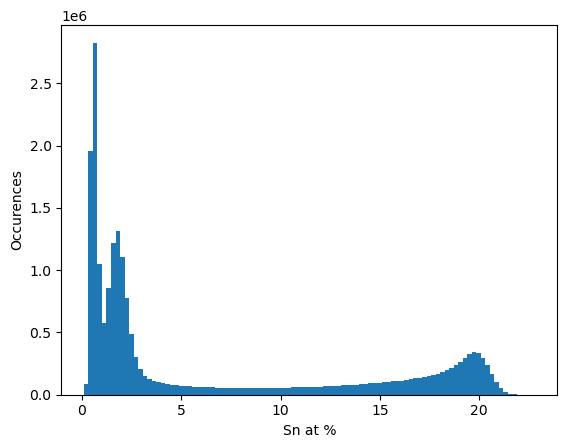

In [46]:
fig = plt.figure()
plt.hist(Sn_at.flatten(),bins=100)
plt.xlabel('Sn at %')
plt.ylabel('Occurences')
plt.show()
fig.savefig('figs/Sn_histogram')

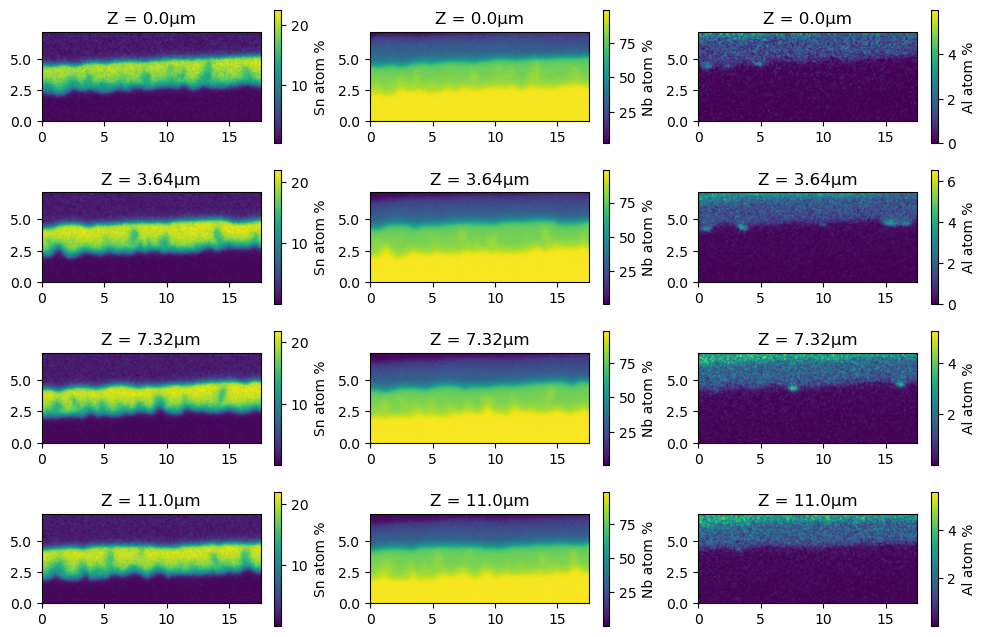

In [43]:
slices = np.linspace(1, image_resolution[2]-1,num=4)

bounds = [0,image_resolution[0]*pixel_size[0],
          0,image_resolution[1]*pixel_size[1],
          0,image_resolution[2]*pixel_size[2],]



fig, axs = plt.subplots(4,3,figsize=(12,8))

for i, z_slice in enumerate(slices):
    z_index = int(z_slice)-1


    im = axs[i,0].imshow(Sn_at[:,:,z_index].T,extent=bounds[0:4])
    axs[i,0].set_title('Z = '+str(round(z_index*pixel_size[2],2))+'μm')
    cbar = fig.colorbar(im, ax=axs[i,0])
    cbar.ax.set_ylabel('Sn atom %')

    im = axs[i,1].imshow(Nb_at[:,:,z_index].T,extent=bounds[0:4])
    axs[i,1].set_title('Z = '+str(round(z_index*pixel_size[2],2))+'μm')
    cbar = fig.colorbar(im, ax=axs[i,1])
    cbar.ax.set_ylabel('Nb atom %')

    im = axs[i,2].imshow(Al_at[:,:,z_index].T,extent=bounds[0:4])
    axs[i,2].set_title('Z = '+str(round(z_index*pixel_size[2],2))+'μm')
    cbar = fig.colorbar(im, ax=axs[i,2])
    cbar.ax.set_ylabel('Al atom %')


fig.savefig('figs/slices.png')
